>index

```
Step 1. 가설 설명 및 데이터 분포 확인
     1-1. 수치형, 범주형 컬럼 구분
     1-2. 범주형 데이터 분포 시각화
     1-3. 수치형 데이터 분포 시각화
     1-4. 범주형 데이터 Null 값 확인
     1-5. Null 값에 대해 최빈값 채우기
Step 2. 데이터 전처리
     2-1. Feature X와 예측값 y로 구분
     2-2. 예측값 y에 대해 원핫 인코딩
     2-3. 범주형 Feature X에 대해 원핫 인코딩
     2-4. 학습, 평가 데이터 구분
     2-5. 수치형 Feature 표준화
     2-6. 범주형 Feature 차원축소(PCA) 및 표준화
     2-7. 수치형 Feature와 범주형 Feature 병합
     2-8. Feature 분포 확인
Step 3. 모델링 및 예측
     3-1. Logistic Regression
     3-2. Random Forest
     3-3. XGBoost
     3-4. Light GBM
     3-5. Deep Learning
Step 4. 결론
```

# 딥러닝 신경망 모형이 언제나 이길까?

본 분석은 머신러닝 모델의 예측 성능을 비교함으로써 딥러닝(다층 신경망)이 언제나 만능일 수 없음을 검증하고자 합니다. 물론 신경망의 경우 Hyper-parameter 튜닝 및 딥러닝에 최적화된 Feature Engineering을 통해 미세한 성능 개선이 가능하지만, 단순 이진 분류의 경우에 딥러닝보다 빠른 속도와 우수한 성능을 보여주는 가벼운 머신러닝 모델을 쉽게 찾을 수 있음을 보여주기 위함입니다.
그럼, 자연스럽게 가설을 하나 설정해두고 분석을 진행하도록 하겠습니다.


## Step 1. 가설 설정 및 데이터 분포 확인

- 귀무가설 : 동일한 데이터로 동일한 정규화 과정을 거쳤을 때 머신러닝 모델 중 신경망 알고리즘의 성능이 가장 우수하다.
- 연구가설 : 동일한 데이터로 동일한 정규화 과정을 거쳤을 때 머신러닝 모델 중 신경망 알고리즘의 성능이 가장 우수한 것은 아니다.

데이터는 UCI Machine Learning Repository의 Adult Data Set을 사용합니다. 해당 데이터는 소득 예측을 위한 정보를 담고 있으며, 연 $ 50K 이하 혹은 초과 케이스에 대한 label(y)를 함께 제공하고 있습니다.

In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import OneHotEncoder
from sklearn.decomposition import PCA

from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier

from xgboost import XGBClassifier
from lightgbm import LGBMClassifier

from keras import models
from keras import layers

from sklearn.metrics import classification_report

import warnings
warnings.filterwarnings(action='ignore')
plt.style.use(['seaborn'])

pd.set_option('display.precision', 2)
pd.options.display.float_format = '{:.2f}'.format

In [4]:
col_names = ['age', 'workclass', 'fnlwgt', 'education', 'education-num', 'marital-status', 'occupation', 'relationship', 'race', 'sex', 'capital-gain', 'capital-loss', 'hours-per-week', 'native-country', 'income']
df = pd.read_csv('./data/adult.data', names=col_names)
df.head(10)

,age,workclass,fnlwgt,education,education-num,marital-status,occupation,relationship,race,sex,capital-gain,capital-loss,hours-per-week,native-country,income
0,39,State-gov,77516,Bachelors,13,Never-married,Adm-clerical,Not-in-family,White,Male,2174,0,40,United-States,<=50K
1,50,Self-emp-not-inc,83311,Bachelors,13,Married-civ-spouse,Exec-managerial,Husband,White,Male,0,0,13,United-States,<=50K
2,38,Private,215646,HS-grad,9,Divorced,Handlers-cleaners,Not-in-family,White,Male,0,0,40,United-States,<=50K
3,53,Private,234721,11th,7,Married-civ-spouse,Handlers-cleaners,Husband,Black,Male,0,0,40,United-States,<=50K
4,28,Private,338409,Bachelors,13,Married-civ-spouse,Prof-specialty,Wife,Black,Female,0,0,40,Cuba,<=50K
5,37,Private,284582,Masters,14,Married-civ-spouse,Exec-managerial,Wife,White,Female,0,0,40,United-States,<=50K
6,49,Private,160187,9th,5,Married-spouse-absent,Other-service,Not-in-family,Black,Female,0,0,16,Jamaica,<=50K
7,52,Self-emp-not-inc,209642,HS-grad,9,Married-civ-spouse,Exec-managerial,Husband,White,Male,0,0,45,United-States,>50K
8,31,Private,45781,Masters,14,Never-married,Prof-specialty,Not-in-family,White,Female,14084,0,50,United-States,>50K
9,42,Private,159449,Bachelors,13,Married-civ-spouse,Exec-managerial,Husband,White,Male,5178,0,40,United-States,>50K


In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 32561 entries, 0 to 32560
Data columns (total 15 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   age             32561 non-null  int64 
 1   workclass       32561 non-null  object
 2   fnlwgt          32561 non-null  int64 
 3   education       32561 non-null  object
 4   education-num   32561 non-null  int64 
 5   marital-status  32561 non-null  object
 6   occupation      32561 non-null  object
 7   relationship    32561 non-null  object
 8   race            32561 non-null  object
 9   sex             32561 non-null  object
 10  capital-gain    32561 non-null  int64 
 11  capital-loss    32561 non-null  int64 
 12  hours-per-week  32561 non-null  int64 
 13  native-country  32561 non-null  object
 14  income          32561 non-null  object
dtypes: int64(6), object(9)
memory usage: 3.7+ MB


### 1-1. 수치형, 범주형 컬럼 구분

각 컬럼은 범주형, 수치형 데이터가 섞여 있으며 각각의 분포를 나눠 살펴보겠습니다.

In [6]:
num_cols = []
cat_cols = []
for col in df.columns:
    if df[col].dtype == 'int64':
        num_cols.append(col)
    else:
        cat_cols.append(col)

print(f'num_cols : {len(num_cols)} cat_cols : {len(cat_cols)} all_cols : {len(df.columns)}')
        

num_cols : 6 cat_cols : 9 all_cols : 15


### 1-2. 범주형 데이터 분포 시각화

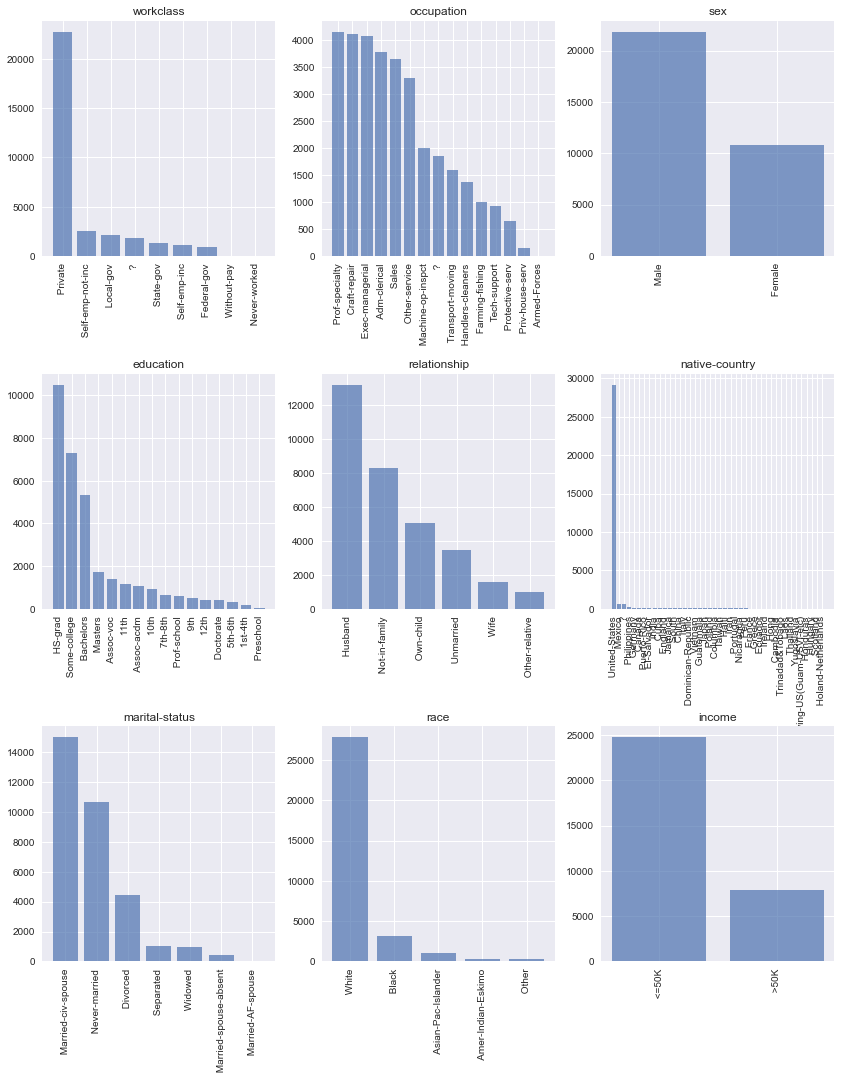

In [9]:
fig, axes = plt.subplots(nrows=3, ncols=3)
for i in range(len(cat_cols)):
    x = df[cat_cols[i]].value_counts().index
    y = df[cat_cols[i]].value_counts().values
    axes[i%3, i//3].bar(x=x, height=y, alpha=0.7)
    axes[i%3, i//3].set_title(cat_cols[i])
    axes[i%3, i//3].set_xticklabels(x, rotation=90)

plt.subplots_adjust(top=2.5, hspace=0.5, right=1.5)
plt.show()

### 1-3. 수치형 데이터 분포 시각화

In [10]:
df[num_cols].describe()

,age,fnlwgt,education-num,capital-gain,capital-loss,hours-per-week
count,32561.00,32561.00,32561.00,32561.00,32561.00,32561.00
mean,38.58,189778.37,10.08,1077.65,87.30,40.44
std,13.64,105549.98,2.57,7385.29,402.96,12.35
min,17.00,12285.00,1.00,0.00,0.00,1.00
25%,28.00,117827.00,9.00,0.00,0.00,40.00
50%,37.00,178356.00,10.00,0.00,0.00,40.00
75%,48.00,237051.00,12.00,0.00,0.00,45.00
max,90.00,1484705.00,16.00,99999.00,4356.00,99.00


In [11]:
for i in  range(len(num_cols)):
    print(i//3, i%3)

0 0
0 1
0 2
1 0
1 1
1 2


In [12]:
num_cols

['age',
 'fnlwgt',
 'education-num',
 'capital-gain',
 'capital-loss',
 'hours-per-week']

In [13]:
df[num_cols[0]].value_counts().sort_index()

17    395
18    550
19    712
20    753
21    720
     ... 
85      3
86      1
87      1
88      3
90     43
Name: age, Length: 73, dtype: int64

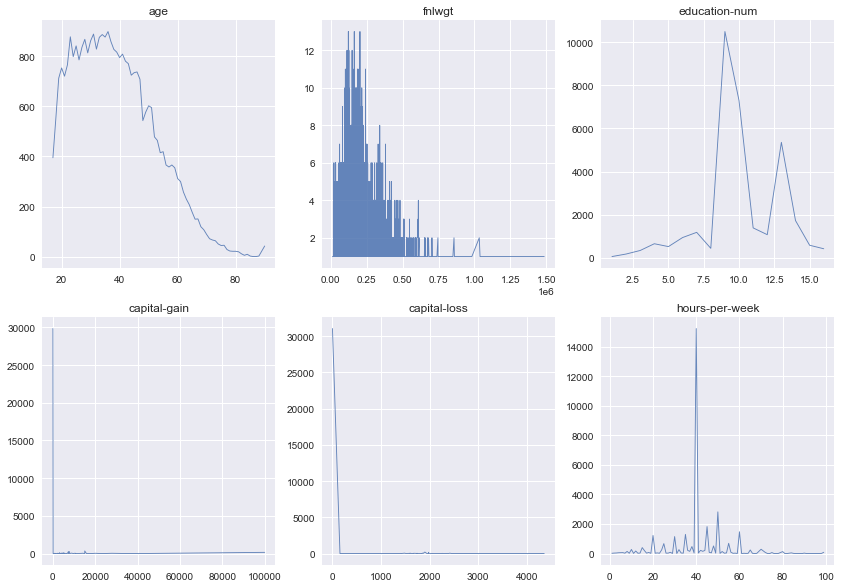

In [16]:
fig, axes = plt.subplots(nrows=2, ncols=3)
for i in range(len(num_cols)):
    srs = df[num_cols[i]].value_counts().sort_index()
    x = srs.index
    y = srs.values
    axes[i//3, i%3].plot(x, y, alpha=0.85, linewidth=0.9)
    axes[i//3, i%3].set_title(num_cols[i])

plt.subplots_adjust(top=1.5, hspace=0.2, right=1.5)

### 1-4. 범주형 데이터 Null 값 확인

In [17]:
value_dicts = {}
for col in cat_cols:
    value_dicts[col] = df[col].value_counts()

In [18]:
value_dicts

{'workclass':  Private             22696
  Self-emp-not-inc     2541
  Local-gov            2093
  ?                    1836
  State-gov            1298
  Self-emp-inc         1116
  Federal-gov           960
  Without-pay            14
  Never-worked            7
 Name: workclass, dtype: int64,
 'education':  HS-grad         10501
  Some-college     7291
  Bachelors        5355
  Masters          1723
  Assoc-voc        1382
  11th             1175
  Assoc-acdm       1067
  10th              933
  7th-8th           646
  Prof-school       576
  9th               514
  12th              433
  Doctorate         413
  5th-6th           333
  1st-4th           168
  Preschool          51
 Name: education, dtype: int64,
 'marital-status':  Married-civ-spouse       14976
  Never-married            10683
  Divorced                  4443
  Separated                 1025
  Widowed                    993
  Married-spouse-absent      418
  Married-AF-spouse           23
 Name: marital-status, dt

### 1-5. Null 값에 대해 최빈값 채우기

In [19]:
col_have_null = []
for col in cat_cols:
    if ' ?' in value_dicts[col].index:
        col_have_null.append(col)
        
print(col_have_null)

['workclass', 'occupation', 'native-country']


In [20]:
df[col].value_counts()

 <=50K    24720
 >50K      7841
Name: income, dtype: int64

In [21]:
for col in col_have_null:
    md = df[col].mode()
    df[col].replace({' ?':md.values[0]}, inplace=True)
    print(df[col].value_counts())


 Private             24532
 Self-emp-not-inc     2541
 Local-gov            2093
 State-gov            1298
 Self-emp-inc         1116
 Federal-gov           960
 Without-pay            14
 Never-worked            7
Name: workclass, dtype: int64
 Prof-specialty       5983
 Craft-repair         4099
 Exec-managerial      4066
 Adm-clerical         3770
 Sales                3650
 Other-service        3295
 Machine-op-inspct    2002
 Transport-moving     1597
 Handlers-cleaners    1370
 Farming-fishing       994
 Tech-support          928
 Protective-serv       649
 Priv-house-serv       149
 Armed-Forces            9
Name: occupation, dtype: int64
 United-States                 29753
 Mexico                          643
 Philippines                     198
 Germany                         137
 Canada                          121
 Puerto-Rico                     114
 El-Salvador                     106
 India                           100
 Cuba                             95
 England    

## Step 2. 데이터 전처리

머신러닝 학습을 위해 다음의 전처리가 필요합니다.
- 머신러닝의 경우 모든 학습 데이터가 수치로 입력되어야 하므로 One-Hot-Encoding 방식을 사용해 범주형 데이터를 모두 변환해줍니다.
- 이때 데이터가 희소해지는 현상(One-Hot-Encoding시 데이터는 0과 1로 채워지며 0이 1에 비해 많은 공간을 차지하므로 머신러닝의 학습이 원활하지 못하게 됨)에 대응하여 차원 축소(PCA, Principal Component Analysis)도 함께 수행해주었습니다.

관련하여 순차적으로 필요한 작업을 수행하도록 하겠습니다.

### 2-1. Feature X와 예측값 y로 구분

In [22]:
raw_y = df['income']
raw_X = df.drop(['income'], axis=1)

print(raw_X.shape, raw_y.shape)

(32561, 14) (32561,)


### 2-2. 예측값 y에 대해 원핫 인코딩

In [23]:
raw_y

0         <=50K
1         <=50K
2         <=50K
3         <=50K
4         <=50K
          ...  
32556     <=50K
32557      >50K
32558     <=50K
32559     <=50K
32560      >50K
Name: income, Length: 32561, dtype: object

In [24]:
raw_y.value_counts()

 <=50K    24720
 >50K      7841
Name: income, dtype: int64

In [25]:
raw_y.apply(lambda x : 0 if x == ' <=50K' else 1).value_counts()

0    24720
1     7841
Name: income, dtype: int64

In [26]:
y = raw_y.apply(lambda x : 0 if x == ' <=50K' else 1)
y

0        0
1        0
2        0
3        0
4        0
        ..
32556    0
32557    1
32558    0
32559    0
32560    1
Name: income, Length: 32561, dtype: int64

### 2-3. 범주형 Feature X에 대해 원핫 인코딩

In [27]:
cat_cols

['workclass',
 'education',
 'marital-status',
 'occupation',
 'relationship',
 'race',
 'sex',
 'native-country',
 'income']

In [28]:
cat_cols.remove('income')
print(cat_cols)

['workclass', 'education', 'marital-status', 'occupation', 'relationship', 'race', 'sex', 'native-country']


In [29]:
raw_X[cat_cols]

,workclass,education,marital-status,occupation,relationship,race,sex,native-country
0,State-gov,Bachelors,Never-married,Adm-clerical,Not-in-family,White,Male,United-States
1,Self-emp-not-inc,Bachelors,Married-civ-spouse,Exec-managerial,Husband,White,Male,United-States
2,Private,HS-grad,Divorced,Handlers-cleaners,Not-in-family,White,Male,United-States
3,Private,11th,Married-civ-spouse,Handlers-cleaners,Husband,Black,Male,United-States
4,Private,Bachelors,Married-civ-spouse,Prof-specialty,Wife,Black,Female,Cuba
...,...,...,...,...,...,...,...,...
32556,Private,Assoc-acdm,Married-civ-spouse,Tech-support,Wife,White,Female,United-States
32557,Private,HS-grad,Married-civ-spouse,Machine-op-inspct,Husband,White,Male,United-States
32558,Private,HS-grad,Widowed,Adm-clerical,Unmarried,White,Female,United-States
32559,Private,HS-grad,Never-married,Adm-clerical,Own-child,White,Male,United-States


In [30]:
num_X = raw_X[num_cols]
cat_X = raw_X[cat_cols]

cat_X = pd.get_dummies(cat_X)
cat_X

,workclass_ Federal-gov,workclass_ Local-gov,workclass_ Never-worked,workclass_ Private,workclass_ Self-emp-inc,workclass_ Self-emp-not-inc,workclass_ State-gov,workclass_ Without-pay,education_ 10th,education_ 11th,...,native-country_ Portugal,native-country_ Puerto-Rico,native-country_ Scotland,native-country_ South,native-country_ Taiwan,native-country_ Thailand,native-country_ Trinadad&Tobago,native-country_ United-States,native-country_ Vietnam,native-country_ Yugoslavia
0,0,0,0,0,0,0,1,0,0,0,...,0,0,0,0,0,0,0,1,0,0
1,0,0,0,0,0,1,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
2,0,0,0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
3,0,0,0,1,0,0,0,0,0,1,...,0,0,0,0,0,0,0,1,0,0
4,0,0,0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
32556,0,0,0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
32557,0,0,0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
32558,0,0,0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
32559,0,0,0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0


In [31]:
X = pd.concat([num_X, cat_X], axis=1)
X

,age,fnlwgt,education-num,capital-gain,capital-loss,hours-per-week,workclass_ Federal-gov,workclass_ Local-gov,workclass_ Never-worked,workclass_ Private,...,native-country_ Portugal,native-country_ Puerto-Rico,native-country_ Scotland,native-country_ South,native-country_ Taiwan,native-country_ Thailand,native-country_ Trinadad&Tobago,native-country_ United-States,native-country_ Vietnam,native-country_ Yugoslavia
0,39,77516,13,2174,0,40,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
1,50,83311,13,0,0,13,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
2,38,215646,9,0,0,40,0,0,0,1,...,0,0,0,0,0,0,0,1,0,0
3,53,234721,7,0,0,40,0,0,0,1,...,0,0,0,0,0,0,0,1,0,0
4,28,338409,13,0,0,40,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
32556,27,257302,12,0,0,38,0,0,0,1,...,0,0,0,0,0,0,0,1,0,0
32557,40,154374,9,0,0,40,0,0,0,1,...,0,0,0,0,0,0,0,1,0,0
32558,58,151910,9,0,0,40,0,0,0,1,...,0,0,0,0,0,0,0,1,0,0
32559,22,201490,9,0,0,20,0,0,0,1,...,0,0,0,0,0,0,0,1,0,0


### 2-4. 학습, 평가 데이터 구분

In [186]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25)
print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)

(24420, 105) (8141, 105) (24420,) (8141,)


In [199]:
num_X_train = X_train[num_cols]
num_X_test = X_test[num_cols]

sparse_X_train = X_train.drop(num_cols, axis=1)
sparse_X_test = X_test.drop(num_cols, axis=1)

### 2-5. 수치형 Feature 표준화

In [310]:
scaler = StandardScaler()

X_train_scaled_arr = scaler.fit_transform(num_X_train)
X_train_scaled = pd.DataFrame(X_train_scaled_arr, columns = num_cols)

X_test_scaled_arr = scaler.transform(num_X_test)
X_test_scaled = pd.DataFrame(X_test_scaled_arr, columns=num_cols)

In [311]:
X_train_scaled

,age,fnlwgt,education-num,capital-gain,capital-loss,hours-per-week
0,-0.55,-0.11,1.13,1.67,-0.21,1.59
1,0.76,-0.68,-0.03,-0.15,-0.21,-0.03
2,-0.92,0.37,-0.42,-0.15,-0.21,-0.03
3,-0.99,1.46,-0.42,-0.15,-0.21,0.78
4,-1.21,-0.62,0.36,-0.15,-0.21,-0.84
...,...,...,...,...,...,...
24415,1.13,0.34,-0.03,-0.15,-0.21,0.78
24416,-1.36,-0.62,-0.42,-0.15,-0.21,-0.84
24417,-0.41,-0.15,-0.42,-0.15,3.51,-0.19
24418,0.98,0.89,-0.03,-0.15,-0.21,0.38


In [312]:
X_test_scaled

,age,fnlwgt,education-num,capital-gain,capital-loss,hours-per-week
0,-0.77,0.00,1.52,-0.15,-0.21,-0.03
1,0.25,0.00,0.36,-0.15,-0.21,-0.03
2,0.76,-0.64,1.52,-0.15,-0.21,0.38
3,-0.26,0.80,-2.37,-0.15,-0.21,3.22
4,-0.12,1.27,-0.42,-0.15,-0.21,1.59
...,...,...,...,...,...,...
8136,1.20,0.22,-1.20,-0.15,-0.21,-0.03
8137,-0.92,-0.56,1.13,-0.15,-0.21,-0.44
8138,0.25,0.43,0.75,-0.15,-0.21,0.78
8139,-0.12,-0.54,-0.42,-0.15,-0.21,-0.03


### 2-6. 범주형 Feature 차원축소(PCA) 및 표준화

In [313]:
pca = PCA(n_components=3)
pca_cols = ["red_1", "red_2", "red_3"]

X_train_reduced_arr = pca.fit_transform(sparse_X_train)
X_train_reduced = pd.DataFrame(X_train_reduced_arr, columns=pca_cols)

X_test_reduced_arr = pca.transform(sparse_X_test)
X_test_reduced = pd.DataFrame(X_test_reduced_arr, columns=pca_cols)

In [314]:
X_train_reduced

,red_1,red_2,red_3
0,1.37,0.07,-0.55
1,-1.06,0.12,-0.66
2,1.05,0.60,0.87
3,-0.96,0.04,0.80
4,1.27,-0.06,-0.15
...,...,...,...
24415,-1.09,0.12,-0.67
24416,1.22,-0.12,0.71
24417,0.27,1.09,0.43
24418,-1.04,-0.12,-0.25


In [209]:
X_test_reduced

,red_1,red_2,red_3
0,0.408474,-0.987883,-0.413004
1,0.947914,0.958552,0.087762
2,-1.088312,0.279224,-0.655309
3,0.921724,0.828556,0.120947
4,0.345637,-0.992845,0.586675
...,...,...,...
8136,1.067648,0.961088,0.190738
8137,1.117162,0.161710,-0.789094
8138,-1.086795,-0.053501,0.072100
8139,0.936498,0.949841,0.880186


In [315]:
pca_cols

['red_1', 'red_2', 'red_3']

In [316]:
scaler = StandardScaler()

X_train_reduced_scaled_arr = scaler.fit_transform(X_train_reduced)
X_train_reduced_scaled = pd.DataFrame(X_train_reduced_scaled_arr, columns=pca_cols)

X_test_reduced_scaled_arr = scaler.transform(X_test_reduced)
X_test_reduced_scaled = pd.DataFrame(X_test_reduced_scaled_arr, columns=pca_cols)

이렇게 범주형 변수도 수치화한 다음 머신러닝 모델에 바로 입력하지 않고 표준화를 거치는 것이 좋습니다. 데이터의 평균 및 분산이 컬럼마다 다르게 되면 수치상 평균이 큰 특정 칼럼에 대한 영향이 다른 칼럼들의 분포를 상쇄시키기 때문입니다.

### 2-7. 수치형 Feature와 범주형 Feature 병합

In [317]:
X_train = pd.concat([X_train_scaled, X_train_reduced_scaled], axis=1)
X_test = pd.concat([X_test_scaled, X_test_reduced_scaled], axis=1)

print(X_train.shape, X_test.shape)

(24420, 9) (8141, 9)


In [318]:
X_train

,age,fnlwgt,education-num,capital-gain,capital-loss,hours-per-week,red_1,red_2,red_3
0,-0.55,-0.11,1.13,1.67,-0.21,1.59,1.48,0.13,-1.00
1,0.76,-0.68,-0.03,-0.15,-0.21,-0.03,-1.14,0.20,-1.20
2,-0.92,0.37,-0.42,-0.15,-0.21,-0.03,1.13,1.01,1.59
3,-0.99,1.46,-0.42,-0.15,-0.21,0.78,-1.04,0.07,1.46
4,-1.21,-0.62,0.36,-0.15,-0.21,-0.84,1.37,-0.10,-0.27
...,...,...,...,...,...,...,...,...,...
24415,1.13,0.34,-0.03,-0.15,-0.21,0.78,-1.17,0.20,-1.23
24416,-1.36,-0.62,-0.42,-0.15,-0.21,-0.84,1.32,-0.21,1.30
24417,-0.41,-0.15,-0.42,-0.15,3.51,-0.19,0.29,1.85,0.78
24418,0.98,0.89,-0.03,-0.15,-0.21,0.38,-1.12,-0.20,-0.45


In [319]:
X_test

,age,fnlwgt,education-num,capital-gain,capital-loss,hours-per-week,red_1,red_2,red_3
0,-0.77,0.00,1.52,-0.15,-0.21,-0.03,0.44,-1.67,-0.75
1,0.25,0.00,0.36,-0.15,-0.21,-0.03,1.02,1.62,0.16
2,0.76,-0.64,1.52,-0.15,-0.21,0.38,-1.17,0.47,-1.19
3,-0.26,0.80,-2.37,-0.15,-0.21,3.22,0.99,1.40,0.22
4,-0.12,1.27,-0.42,-0.15,-0.21,1.59,0.37,-1.68,1.07
...,...,...,...,...,...,...,...,...,...
8136,1.20,0.22,-1.20,-0.15,-0.21,-0.03,1.15,1.63,0.35
8137,-0.92,-0.56,1.13,-0.15,-0.21,-0.44,1.20,0.27,-1.44
8138,0.25,0.43,0.75,-0.15,-0.21,0.78,-1.17,-0.09,0.13
8139,-0.12,-0.54,-0.42,-0.15,-0.21,-0.03,1.01,1.61,1.60


### 2-8. Feature 분포 확인

In [321]:
X_train.describe()

,age,fnlwgt,education-num,capital-gain,capital-loss,hours-per-week,red_1,red_2,red_3
count,24420.00,24420.00,24420.00,24420.00,24420.00,24420.00,24420.00,24420.00,24420.00
mean,-0.00,0.00,-0.00,0.00,0.00,-0.00,-0.00,0.00,-0.00
std,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00
min,-1.58,-1.66,-3.54,-0.15,-0.21,-3.20,-1.34,-2.07,-1.88
25%,-0.77,-0.68,-0.42,-0.15,-0.21,-0.03,-1.10,-0.31,-0.77
50%,-0.12,-0.11,-0.03,-0.15,-0.21,-0.03,0.30,0.04,-0.34
75%,0.69,0.45,0.75,-0.15,-0.21,0.38,0.99,0.43,1.07
max,3.76,12.20,2.30,12.75,10.70,4.76,1.64,2.34,2.17


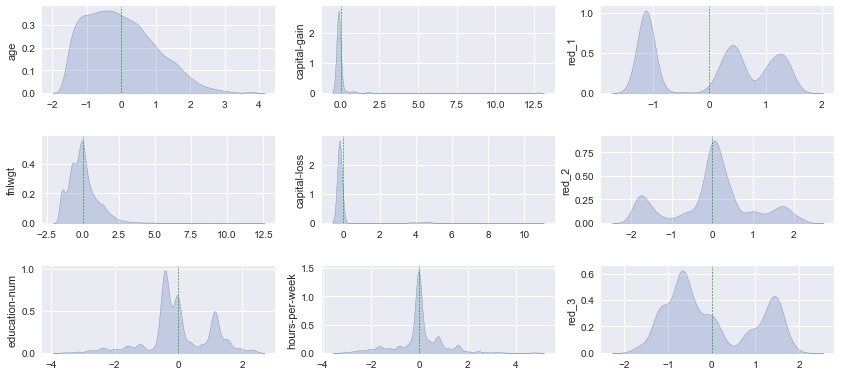

In [332]:
X_cols = X_train.columns

fig, axes = plt.subplots(nrows=3, ncols=3)
for i in range(len(X_cols)):
    sns.kdeplot(x=X_train[X_cols[i]].values, shade=True, ax=axes[i%3, i//3])
    axes[i%3, i//3].set_ylabel(X_cols[i])
    axes[i%3, i//3].axvline(x=0, color='g', linestyle='--', linewidth=0.6)

plt.subplots_adjust(top=1.0, hspace=0.5, right=1.5)

In [330]:
X_test.describe()

,age,fnlwgt,education-num,capital-gain,capital-loss,hours-per-week,red_1,red_2,red_3
count,8141.00,8141.00,8141.00,8141.00,8141.00,8141.00,8141.00,8141.00,8141.00
mean,0.00,-0.02,-0.01,-0.03,0.02,0.02,-0.00,0.01,-0.02
std,0.99,0.98,1.01,0.79,1.04,1.01,1.00,1.01,0.99
min,-1.58,-1.68,-3.54,-0.15,-0.21,-3.20,-1.34,-2.06,-1.88
25%,-0.77,-0.68,-0.42,-0.15,-0.21,-0.03,-1.11,-0.31,-0.77
50%,-0.12,-0.12,-0.03,-0.15,-0.21,-0.03,0.30,0.04,-0.35
75%,0.69,0.42,0.75,-0.15,-0.21,0.38,0.98,0.44,1.01
max,3.76,9.77,2.30,12.75,9.23,4.76,1.63,2.32,2.17


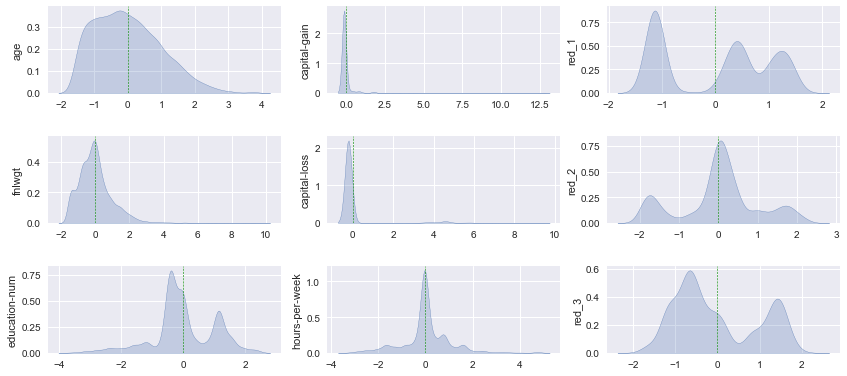

In [331]:
fig, axes = plt.subplots(nrows=3, ncols=3)
for i in range(len(X_cols)):
    sns.kdeplot(x=X_test[X_cols[i]].values, shade=True, ax=axes[i%3, i//3])
    axes[i%3, i//3].set_ylabel(X_cols[i])
    axes[i%3, i//3].axvline(x=0, color='g', linestyle='--', linewidth=0.6)

plt.subplots_adjust(top=1.0, hspace=0.5, right=1.5)

In [357]:
y_train.value_counts()

0    18549
1     5871
Name: income, dtype: int64

In [335]:
y_test.value_counts()


0    6171
1    1970
Name: income, dtype: int64

## Step 3. 모델링 및 예측

해당 데이터에 대해 총 5개의 머신러닝 모델로 예측을 수행합니다.

### 3-1. Logistic Regression

In [337]:
lr = LogisticRegression()

lr.fit(X_train, y_train)
pred = lr.predict(X_test)

In [350]:
print('Accuracy : {:.2f}'.format((y_test == pred).sum() / len(y_test)))

Accuracy : 0.84


In [351]:
report = classification_report(y_test, pred)
print(report)


              precision    recall  f1-score   support

           0       0.87      0.93      0.90      6171
           1       0.72      0.56      0.63      1970

    accuracy                           0.84      8141
   macro avg       0.79      0.74      0.76      8141
weighted avg       0.83      0.84      0.83      8141



- 0 : <=50K
- 1 :  >50K 
---
Precision
- 연소득 $50,000 이하로 예측한 케이스의 87% 일치
- 연소득 $50,000 초과로 예측한 케이스의 72% 일치

Recall
- 실제 연소득 $50,000 이하 케이스 중 93% 정상 분류
- 실제 연소득 $50,000 초과 케이스 중 56% 정상 분류

> 데이터 불균형으로 연소득 $50,000에 대한 예측 성능이 더 우수

### 3-2. Random Forest

In [355]:
rfc = RandomForestClassifier()
rfc.fit(X_train, y_train)

pred = rfc.predict(X_test)
print('Accuracy : {:.2f}'.format((pred==y_test).sum()/len(pred)))

Accuracy : 0.86


In [356]:
report = classification_report(y_test, pred)
print(report)


              precision    recall  f1-score   support

           0       0.89      0.93      0.91      6171
           1       0.74      0.62      0.68      1970

    accuracy                           0.86      8141
   macro avg       0.81      0.78      0.79      8141
weighted avg       0.85      0.86      0.85      8141



Precision
- 연소득 $50,000 이하로 예측한 케이스의 89% 일치
- 연소득 $50,000 초과로 예측한 케이스의 74% 일치

Recall
- 실제 연소득 $50,000 이하 케이스 중 93% 정상 분류
- 실제 연소득 $50,000 초과 케이스 중 62% 정상 분류

> 마찬가지로 데이터 불균형으로 연소득 $50,000에 대한 예측 성능이 더 우수하지만 Linear Model보다 부족한 데이터셋에 대한 예측력이 좋음

### 3-3. XGBoost

In [360]:
xgb = XGBClassifier()
xgb.fit(X_train, y_train)
pred = xgb.predict(X_test)

print('Accuracy : {:.2f}'.format((pred==y_test).sum()/len(pred)))

Accuracy : 0.87


In [361]:
report = classification_report(y_test, pred)
print(report)


              precision    recall  f1-score   support

           0       0.89      0.94      0.91      6171
           1       0.76      0.65      0.70      1970

    accuracy                           0.87      8141
   macro avg       0.83      0.79      0.81      8141
weighted avg       0.86      0.87      0.86      8141



Precision
- 연소득 $50,000 이하로 예측한 케이스의 89% 일치
- 연소득 $50,000 초과로 예측한 케이스의 76% 일치

Recall
- 실제 연소득 $50,000 이하 케이스 중 94% 정상 분류
- 실제 연소득 $50,000 초과 케이스 중 65% 정상 분류

> 기본 배깅 방식에서 개선된 학습 알고리즘인 랜덤포레스트보다도 부스팅 알고리즘이 성능이 좋았음.

### 3-4. Light GBM

In [364]:
lgbm = LGBMClassifier()
lgbm.fit(X_train, y_train)
pred = lgbm.predict(X_test)

print('Accuracy : {:.2f}'.format((pred==y_test).sum()/len(pred)))

Accuracy : 0.87


In [365]:
report = classification_report(y_test, pred)
print(report)


              precision    recall  f1-score   support

           0       0.89      0.94      0.91      6171
           1       0.76      0.64      0.70      1970

    accuracy                           0.87      8141
   macro avg       0.83      0.79      0.81      8141
weighted avg       0.86      0.87      0.86      8141



Precision
- 연소득 $50,000 이하로 예측한 케이스의 89% 일치
- 연소득 $50,000 초과로 예측한 케이스의 76% 일치

Recall
- 실제 연소득 $50,000 이하 케이스 중 94% 정상 분류
- 실제 연소득 $50,000 초과 케이스 중 64% 정상 분류

> 위에서 확인한 XGBoost와 매우 유사한 수치 확인. 하이퍼파라미터를 사용하지 않는다면 Boosting 계열간 큰 차이는 볼 수 없음

### 3-5. Deep Learning

In [368]:
X_train.shape

(24420, 9)

In [396]:
model = models.Sequential()
model.add(layers.Dense(16, activation='relu', input_shape=(9,)))
model.add(layers.Dense(32, activation='relu'))
model.add(layers.Dense(32, activation='relu'))
model.add(layers.Dense(1, activation='sigmoid'))

model.compile(optimizer='rmsprop', loss='binary_crossentropy', metrics=['accuracy'])

history = model.fit(X_train, y_train,
          epochs=20,
          batch_size=50,
          validation_data=(X_test, y_test))

Epoch 1/20
489/489 [==============================] - 1s 1ms/step - loss: 0.4440 - accuracy: 0.7925 - val_loss: 0.3439 - val_accuracy: 0.8411
Epoch 2/20
489/489 [==============================] - 1s 1ms/step - loss: 0.3328 - accuracy: 0.8412 - val_loss: 0.3373 - val_accuracy: 0.8456
Epoch 3/20
489/489 [==============================] - 0s 872us/step - loss: 0.3255 - accuracy: 0.8462 - val_loss: 0.3300 - val_accuracy: 0.8482
Epoch 4/20
489/489 [==============================] - 0s 895us/step - loss: 0.3171 - accuracy: 0.8516 - val_loss: 0.3292 - val_accuracy: 0.8485
Epoch 5/20
489/489 [==============================] - 1s 1ms/step - loss: 0.3243 - accuracy: 0.8476 - val_loss: 0.3295 - val_accuracy: 0.8444
Epoch 6/20
489/489 [==============================] - 1s 1ms/step - loss: 0.3174 - accuracy: 0.8507 - val_loss: 0.3278 - val_accuracy: 0.8490
Epoch 7/20
489/489 [==============================] - 1s 1ms/step - loss: 0.3200 - accuracy: 0.8502 - val_loss: 0.3279 - val_accuracy: 0.8479
Ep

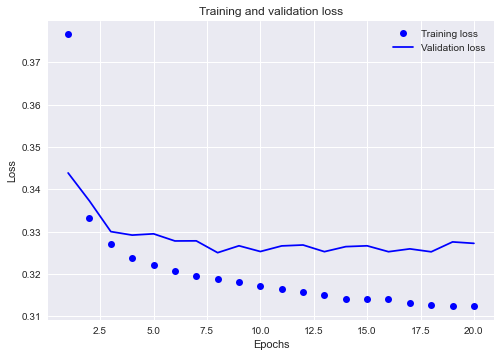

In [397]:
history_dict = history.history
loss = history_dict['loss']
val_loss = history_dict['val_loss']

epochs = range(1, len(loss) + 1)

plt.plot(epochs, loss, 'bo', label='Training loss')  # ‘bo’는 파란색 점을 의미합니다.
plt.plot(epochs, val_loss, 'b', label='Validation loss') # ‘b’는 파란색 실선을 의미합니다.
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

In [399]:
print("test accuracy : {:.2f}".format(max(history_dict['val_accuracy'])))
print("test loss : {:.2f}".format(max(history_dict['val_loss'])))

test accuracy : 0.85
test loss : 0.34


In [410]:
pred = model.predict(X_test)

pred = [0 if x[0] < 0.5 else 1 for x in pred]

report = classification_report(y_test, pred)
print(report)


              precision    recall  f1-score   support

           0       0.89      0.91      0.90      6171
           1       0.70      0.63      0.67      1970

    accuracy                           0.85      8141
   macro avg       0.79      0.77      0.78      8141
weighted avg       0.84      0.85      0.84      8141



Precision
- 연소득 $50,000 이하로 예측한 케이스의 89% 일치
- 연소득 $50,000 초과로 예측한 케이스의 70% 일치

Recall
- 실제 연소득 $50,000 이하 케이스 중 91% 정상 분류
- 실제 연소득 $50,000 초과 케이스 중 63% 정상 분류

> Boosting 계열보다 정확도 떨어짐. Logistic Regression보다 불균형 데이터셋에서 살짝 유리하지만, 큰 차이 없음

## 4. 결론

모델간 성능 비교 결과 Gradient Boosting 계열의 알고리즘(XGBost, LightGBM)의 예측 정확도가 가장 좋았고, 속도를 고려했을 때, LightGBM이 가장 우수했습니다. 따라서 귀무가설을 기각하고 연구가설(동일한 데이터로 동일한 정규화 과정을 거쳤을 때 머신러닝 모델 중 신경망 알고리즘의 성능이 가장 우수한 것은 아니다)을 채택합니다.


실제로 캐글 대회에서도 많은 분석가들이 부스팅 계열 알고리즘으로 빠르고 정확한 모델을 구현해내고 있고, 특히 모델의 연산 속도가 중요한 금융이나 보안 등의 주요 산업 분야에서 부스팅 모델을 선호하는 경향이 있습니다. 

산업 현장에서는 엔지니어의 회고, 피드백 과정을 통한 책임이 중요하기 때문에 모델의 해석 가능성과 설명력이 모델 선택의 주요 기준 중 하나입니다. 이러한 점에서도 신경망 모형보다 부스팅 계열 알고리즘 혹은 랜덤 포레스트 같은 트리 모형이 신경망 보다 유리한 부분이 있습니다.


요즘은 여러 모델을 함께 비교 분석하는 AutoML 패키지가 잘 나와있기 때문에 무조건 딥러닝을 사용하는 것보다 다양한 모델을 비교분석하면서 장단을 따져보는 것이 좋겠습니다.